# Taken's Embedding Theorem

Credit to Tiago Toledo Junior https://github.com/TNanukem/paper_implementations

In this notebook we will explore the Takens embedding theorem and how one can use it to forecast time series using standard machine learning algorithms without relaxing the statistical learning theory lemma that the rows of our dataset must be independent from each other.

We will start by describing the theorem, applying it and comparing its result with the Giotto-TDA implementation and then learn how to parametrize it and how to automatically find the embedding parameters. Then, we will discuss how to use it for forecasting.

## The Theorem

Using the Taken's Theorem we can embedd the time series we have available into a phase space where we do not have a temporal dependence between our data points anymore. This is important because the Statistical Learning Theory only guarantees the learning of an algorithm if the samples (rows or data instances) of our dataset are independent from each other.

In order to define this embedding, we need two hyperparameters named d and m which are the time delay and the embedding dimension respectively. The time delay defines how many data points, previously to the actual one, we will use on the embedding. The dimension will define the final shape of our dataset and how many axies there are in the phase space, each axis representing a time delay.

With those two parameters, given a time series $f(t)$, we will have its embedding as:

$$
\begin{matrix}
f(t) & f(t + d) & \dots & f(t + (m-1)d)\\
f(t+1) & f(t + d + 1) & \dots & f(t + (m-1)d + 1)\\
f(t+2) & f(t + d + 2) & \dots & f(t + (m-1)d) + 2)\\
\dots & \dots & \dots & \\
f(t+(m-1)) & f(t + d + (m -1)) & \dots &  f(t + (m-1)d + (m-1))
\end{matrix}
$$

The idea is that if the series is deterministic enough, then this embedding will generate an attractor on the phase space and we will able to forecast the time series.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from nolitsa import dimension, delay

import plotly.graph_objects as go

from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from openml.datasets.functions import get_dataset

The function below will generate the embedding for a series given the m and the d parameters. We will then compare it with the implementation from the Giotto-TDA library to see if we implemented it correctly.

In [4]:
def takens(data, m=2, d=1):
    emb = np.array([data[0:len(data) - d*m]])
    for i in range(1, m):
        emb = np.append(emb, [data[i*d:len(data) - d*(m - i)]], axis=0)
        
    return emb.T

### Embedding a Sine Function

In [5]:
t = [i for i in np.arange(0, 20, 0.1)]
y = [np.sin(i) for i in t]

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=t, y=y, mode='lines'
))
fig.show()

In [7]:
emb = takens(y)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=[0 for i in range(len(emb[:, 1]))], mode='lines'
))
fig.show()

In [8]:
STE = SingleTakensEmbedding('fixed', 1, 2, n_jobs=-1)
emb = STE.fit_transform(y)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=[0 for i in range(len(emb[:, 1]))], mode='lines'
))
fig.show()

As we can see by the phase-space plot, it seems that our implementation is correct.

### Embedding the Lorenz data

In [72]:
lorenz = get_dataset(42182).get_data(dataset_format='array')[0][:, 0]
lorenz = lorenz.astype(np.float64)
T = lorenz.shape[0]
t = np.arange(T)

lorenz += np.random.randn(T) * 0

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=lorenz, mode='lines'))
fig.show()

In [74]:
emb = takens(lorenz, m=3, d=5)
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 2], mode='lines'
))
fig.show()

In [75]:
STE = SingleTakensEmbedding('fixed', 5, 3, n_jobs=-1)
emb = STE.fit_transform(lorenz)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 2], mode='lines'
))
fig.show()

Again, it seems that the implementation is correct. However, these two datasets have known embedding dimension and time delay parameters for the best attractor. If we are dealing with a real time series we don't know much about, we need a way of estimating these values. This is what we are going to do now.

### Defining the number of dimensions

To define the number of dimensions, we will use the false nearest neighbors. The false nearest neighbors is a metric that defines, given a dimension space, how many points are being considered as neighbors, but are not really neighbors if we unfold the space with one more dimension.

The common use for this metric is to select the first point where the FNN function returns less than 20%. Let's see that for the sine function.

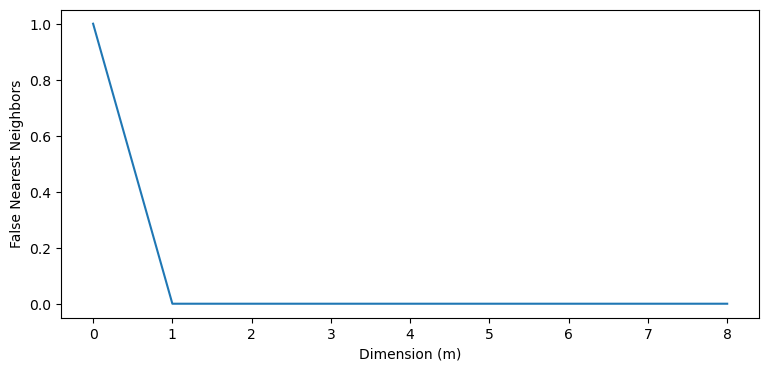

In [83]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(y, tau=4, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (m)')
plt.ylabel('False Nearest Neighbors')
plt.plot(f1)

As we can see, for two dimensions the FNN go below 20%, therefore $m = 2$.

## Find optimal parameters

In [82]:
takens_embedding_optimal_parameters(lorenz, 200, 20)

(185, 14)

By varying the noise level, we can see the it's difficult to estimate the underlying dimension in general.
It will be much more difficult to do this in the multivariate case, or from a single dimension of the observation.
There are a lot to think about if one were to use this in calcium imaging data.